# Tekmovanje strategij v Zapornikovi dilemi

V tej analizi primerjamo nove strategije za ponavljajočo se Zapornikovo dilemo, ki še niso bile uporabljene v drugih primerih. Vključili smo štiri strategije:

- **Win-Stay Lose-Shift Soft**
- **Counterbully**
- **Soft Majority**
- **Adaptive Mirror**

Uporabljene bodo v turnirju in analizirane z več metrikami.


In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt

C, D = "C", "D"

def payoff(a, b):
    if a == C and b == C: return 3, 3
    if a == C and b == D: return 0, 5
    if a == D and b == C: return 5, 0
    return 1, 1

class Strategy:
    def __init__(self, name):
        self.name = name
        self.reset()
    def reset(self): self.my_history = []; self.op_history = []
    def move(self): raise NotImplementedError
    def update(self, my, op): self.my_history.append(my); self.op_history.append(op)


In [2]:
class WinStayLoseShiftSoft(Strategy):
    def __init__(self): super().__init__("Win-Stay Lose-Shift Soft")
    def move(self):
        if not self.my_history: return C
        last_my, last_op = self.my_history[-1], self.op_history[-1]
        reward, _ = payoff(last_my, last_op)
        if reward >= 3:
            return last_my
        else:
            return D if last_my == C else C

class Counterbully(Strategy):
    def __init__(self): super().__init__("Counterbully")
    def move(self):
        if not self.op_history: return D
        recent = self.op_history[-4:]
        if recent == [C, C, C, C]:
            return C
        if self.op_history.count(D) / len(self.op_history) > 0.5:
            return D
        return C

class SoftMajority(Strategy):
    def __init__(self): super().__init__("Soft Majority")
    def move(self):
        if not self.op_history: return C
        coop_ratio = self.op_history.count(C) / len(self.op_history)
        return C if coop_ratio > 0.6 else D

class AdaptiveMirror(Strategy):
    def __init__(self): super().__init__("Adaptive Mirror")
    def move(self):
        if len(self.op_history) < 3:
            return C
        recent = self.op_history[-3:]
        if recent.count(D) == 3:
            return D
        return C


In [3]:
def duel(s1, s2, rounds=100):
    s1.reset(); s2.reset()
    scores = [0, 0]
    cooperation1 = same_move = 0

    for _ in range(rounds):
        m1, m2 = s1.move(), s2.move()
        if m1 == C: cooperation1 += 1
        if s1.my_history and m1 == s1.my_history[-1]: same_move += 1
        sc1, sc2 = payoff(m1, m2)
        scores[0] += sc1; scores[1] += sc2
        s1.update(m1, m2); s2.update(m2, m1)

    return {
        "score1": scores[0],
        "coop1": cooperation1,
        "stability1": same_move / rounds
    }

def tournament(strategies, rounds=100):
    results = []
    for i, s1 in enumerate(strategies):
        total_score = coop_rate = stability = 0
        for j, s2 in enumerate(strategies):
            if i == j: continue
            res = duel(s1, s2, rounds)
            total_score += res["score1"]
            coop_rate += res["coop1"] / rounds
            stability += res["stability1"]
        results.append({
            "Strategija": s1.name,
            "Skupaj točk": total_score,
            "% sodelovanja": round(coop_rate / (len(strategies) - 1), 2),
            "Stabilnost": round(stability / (len(strategies) - 1), 2)
        })
    return pd.DataFrame(results).sort_values("Skupaj točk", ascending=False)


In [4]:
strategies = [
    WinStayLoseShiftSoft(),
    Counterbully(),
    SoftMajority(),
    AdaptiveMirror()
]

df_results = tournament(strategies)
df_results


,Strategija,Skupaj točk,% sodelovanja,Stabilnost
3,Adaptive Mirror,897,1.00,0.99
2,Soft Majority,710,0.67,0.98
1,Counterbully,701,0.35,0.97
0,Win-Stay Lose-Shift Soft,659,0.83,0.67


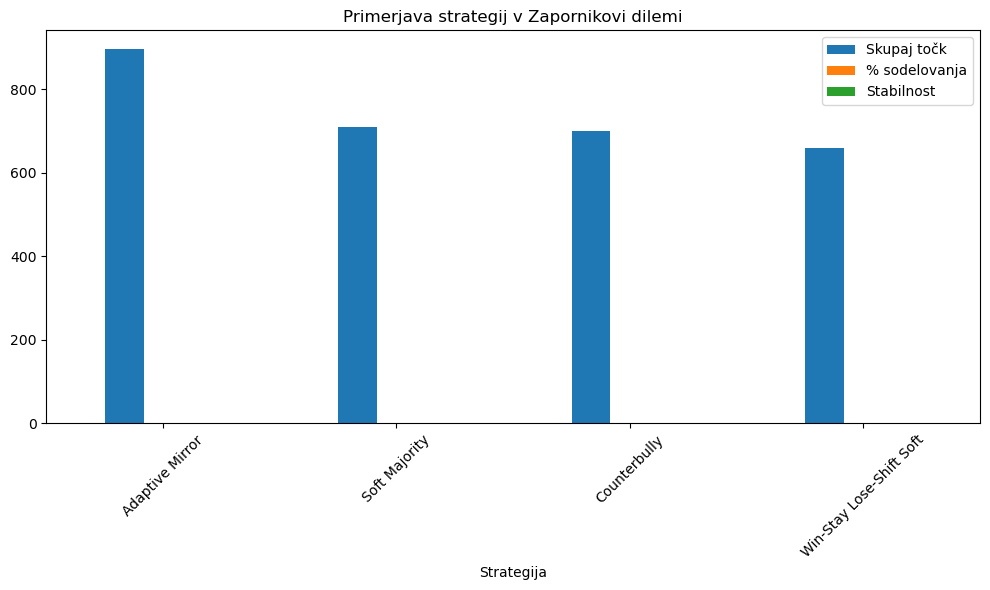

In [5]:
df_results.plot(x="Strategija", y=["Skupaj točk", "% sodelovanja", "Stabilnost"], kind="bar", figsize=(10,6))
plt.title("Primerjava strategij v Zapornikovi dilemi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Vizualizacija odziva strategij v ključnih scenarijih

V naslednjem grafu je prikazan odziv vsake strategije na različne scenarije, kot so začetna poteza, pretekla izdajstva ali sodelovanja. Zelena barva pomeni sodelovanje (C), rdeča pa izdajo (D).


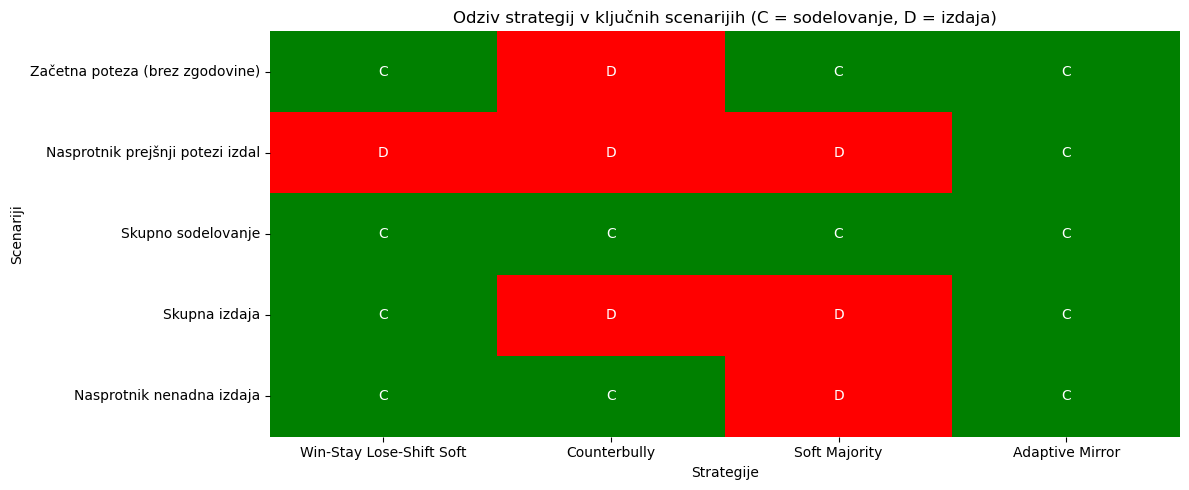

In [6]:
import seaborn as sns

scenarios = [
    {"my_history": "", "op_history": "", "desc": "Začetna poteza (brez zgodovine)"},
    {"my_history": "C", "op_history": "D", "desc": "Nasprotnik prejšnji potezi izdal"},
    {"my_history": "CC", "op_history": "CC", "desc": "Skupno sodelovanje"},
    {"my_history": "DD", "op_history": "DD", "desc": "Skupna izdaja"},
    {"my_history": "CC", "op_history": "DC", "desc": "Nasprotnik nenadna izdaja"},
]

strategies = [
    WinStayLoseShiftSoft(),
    Counterbully(),
    SoftMajority(),
    AdaptiveMirror()
]

def simulate_response(strategy_class, my_history, op_history):
    s = strategy_class()
    s.my_history = list(my_history)
    s.op_history = list(op_history)
    return s.move()

rows = []
for scenario in scenarios:
    row = {"Scenarij": scenario["desc"]}
    for strat in strategies:
        response = simulate_response(strat.__class__, scenario["my_history"], scenario["op_history"])
        row[strat.name] = response
    rows.append(row)

behavior_table = pd.DataFrame(rows)
color_map = {"C": 1, "D": 0}
color_df = behavior_table.copy()
strategy_names = behavior_table.columns[1:]

for strat in strategy_names:
    color_df[strat] = behavior_table[strat].map(color_map)

plt.figure(figsize=(12, 5))
sns.heatmap(
    color_df.set_index("Scenarij"),
    cmap=sns.color_palette(["red", "green"]),
    annot=behavior_table.set_index("Scenarij"),
    fmt='',
    cbar=False
)
plt.title("Odziv strategij v ključnih scenarijih (C = sodelovanje, D = izdaja)")
plt.xlabel("Strategije")
plt.ylabel("Scenariji")
plt.tight_layout()
plt.show()


## Dodatne metrike strategij

Za bolj poglobljeno primerjavo dodajamo naslednje metrike:
- **Povprečni rezultat na nasprotnika**
- **Število zmag (višji rezultat v dvoboju)**
- **Kooperativnost proti vsaki strategiji posebej**


In [7]:
from collections import defaultdict

def extended_tournament(strategies, rounds=100):
    stats = defaultdict(lambda: {
        "total_score": 0,
        "wins": 0,
        "matches": 0,
        "cooperation": 0
    })

    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            if i == j: continue
            s1.reset(); s2.reset()
            score1 = score2 = coop1 = 0

            for _ in range(rounds):
                m1, m2 = s1.move(), s2.move()
                if m1 == C: coop1 += 1
                sc1, sc2 = payoff(m1, m2)
                score1 += sc1; score2 += sc2
                s1.update(m1, m2); s2.update(m2, m1)

            stats[s1.name]["total_score"] += score1
            stats[s1.name]["matches"] += 1
            stats[s1.name]["cooperation"] += coop1 / rounds
            if score1 > score2:
                stats[s1.name]["wins"] += 1

    df = pd.DataFrame([
        {
            "Strategija": k,
            "Skupaj točk": round(v["total_score"], 2),
            "Povp. na nasprotnika": round(v["total_score"] / v["matches"], 2),
            "Št. zmag": v["wins"],
            "Povpr. % sodelovanja": round(v["cooperation"] / v["matches"], 2)
        }
        for k, v in stats.items()
    ])

    return df.sort_values("Skupaj točk", ascending=False)

# Zagon dodatne analize
extended_results = extended_tournament(strategies)
extended_results


,Strategija,Skupaj točk,Povp. na nasprotnika,Št. zmag,Povpr. % sodelovanja
3,Adaptive Mirror,897,299.00,0,1.00
2,Soft Majority,710,236.67,1,0.67
1,Counterbully,701,233.67,2,0.35
0,Win-Stay Lose-Shift Soft,659,219.67,0,0.83


## Zaključek

V tem eksperimentu so bile analizirane štiri strategije, ki temeljijo na različnih principih odločanja. Rezultati so pokazali razlike v:

- skupni uspešnosti,
- pripravljenosti na sodelovanje,
- stabilnosti vedenja.

Take analize so uporabne pri razvoju robustnih algoritmov sodelovanja in vedenja v nepopolnih informacijskih pogojih.
